# Face Detection

In [1]:
from typing import Tuple, Union
import math
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Draw keypoints
    for keypoint in detection.keypoints:
      keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                     width, height)
      color, thickness, radius = (0, 255, 0), 2, 2
      cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    category_name = '' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return annotated_image

(np.float64(-0.5), np.float64(611.5), np.float64(407.5), np.float64(-0.5))

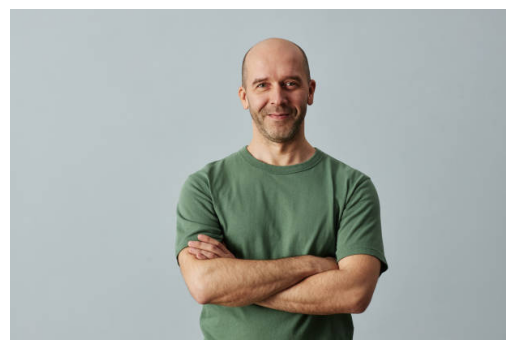

In [2]:
IMAGE_FILE = '/home/asingh/Desktop/uni/ai_acceleration/data_projecte/2.jpg'

import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMAGE_FILE)
img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR → RGB

plt.imshow(img_show)
plt.axis("off")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1766965646.259585   57721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(np.float64(-0.5), np.float64(611.5), np.float64(407.5), np.float64(-0.5))

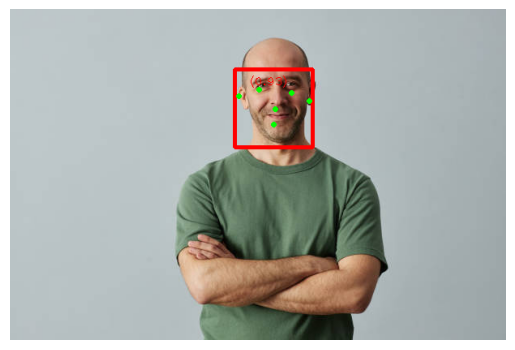

In [3]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceDetector object.
base_options = python.BaseOptions(model_asset_path='/home/asingh/Desktop/uni/ai_acceleration/data_projecte/detector.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect faces in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

rgb_annotated_image_show = cv2.cvtColor(rgb_annotated_image, cv2.COLOR_BGR2RGB)  # Convert BGR → RGB

plt.imshow(rgb_annotated_image_show)
plt.axis("off")

# Embedding Calculations

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import mediapipe as mp
from sys import argv, exit

mp_face = mp.solutions.face_detection


def clamp(v, lo, hi):
    return max(lo, min(hi, v))


def detect_and_crop_largest_face(detector, image_bgr, min_conf=0.6, expand=0.20):
    """
    Detect faces with MediaPipe and return the largest face crop.
    expand adds padding around the box.
    """
    h, w = image_bgr.shape[:2]
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    res = detector.process(image_rgb)

    if not res.detections:
        raise ValueError("No face detected in the image (MediaPipe).")

    best = None
    best_area = 0

    for det in res.detections:
        if det.score and det.score[0] < min_conf:
            continue

        bbox = det.location_data.relative_bounding_box

        # Convert relative bbox -> absolute
        x = int(bbox.xmin * w)
        y = int(bbox.ymin * h)
        bw = int(bbox.width * w)
        bh = int(bbox.height * h)

        # Some detections can yield weird values; skip invalid
        if bw <= 0 or bh <= 0:
            continue

        area = bw * bh
        if area > best_area:
            best_area = area
            best = (x, y, bw, bh)

    if best is None:
        raise ValueError("Faces found but none passed confidence/validity checks.")

    x, y, bw, bh = best

    # Expand bbox
    pad_x = int(bw * expand)
    pad_y = int(bh * expand)

    x0 = clamp(x - pad_x, 0, w - 1)
    y0 = clamp(y - pad_y, 0, h - 1)
    x1 = clamp(x + bw + pad_x, 0, w)
    y1 = clamp(y + bh + pad_y, 0, h)

    crop = image_bgr[y0:y1, x0:x1]
    if crop.size == 0:
        raise ValueError("Face crop failed (empty).")

    return crop


def preprocess_for_tflite(face_bgr, input_details, normalization="arcface"):
    """
    normalization:
      - "arcface": (x - 127.5) / 128.0   -> approx [-1, 1]
      - "0_1": x / 255.0
    """
    shape = input_details[0]["shape"]  # usually [1,H,W,3] (NHWC)
    dtype = input_details[0]["dtype"]

    if len(shape) != 4:
        raise ValueError(f"Unexpected model input shape: {shape}")

    # Determine whether model expects NHWC or NCHW
    # TFLite almost always NHWC; still handle safely.
    if shape[3] == 3:  # NHWC
        in_h, in_w = int(shape[1]), int(shape[2])
        channel_last = True
    elif shape[1] == 3:  # NCHW (rare in TFLite)
        in_h, in_w = int(shape[2]), int(shape[3])
        channel_last = False
    else:
        raise ValueError(f"Cannot infer channel position from input shape: {shape}")

    face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)
    face_resized = cv2.resize(face_rgb, (in_w, in_h), interpolation=cv2.INTER_LINEAR)

    x = face_resized.astype(np.float32)

    if normalization == "arcface":
        x = (x - 127.5) / 128.0
    elif normalization == "0_1":
        x = x / 255.0
    else:
        raise ValueError("normalization must be 'arcface' or '0_1'")

    # Put in correct layout
    if channel_last:
        x = np.expand_dims(x, axis=0)  # [1,H,W,3]
    else:
        x = np.transpose(x, (2, 0, 1))  # [3,H,W]
        x = np.expand_dims(x, axis=0)   # [1,3,H,W]

    # Quantize if needed
    if dtype == np.float32:
        return x.astype(np.float32)

    if dtype == np.int8:
        scale, zero_point = input_details[0]["quantization"]
        if scale == 0:
            raise ValueError("Model is int8 but quantization params invalid (scale=0).")
        q = x / scale + zero_point
        q = np.clip(np.round(q), -128, 127).astype(np.int8)
        return q

    raise ValueError(f"Unsupported input dtype: {dtype}")


def dequantize_output_if_needed(out, output_details):
    dtype = output_details[0]["dtype"]
    if dtype == np.float32:
        return out.astype(np.float32)

    if dtype == np.int8:
        scale, zero_point = output_details[0]["quantization"]
        if scale == 0:
            raise ValueError("Output is int8 but quantization params invalid (scale=0).")
        return (out.astype(np.float32) - zero_point) * scale

    # Some models output uint8, etc. Add if needed.
    raise ValueError(f"Unsupported output dtype: {dtype}")


def l2_normalize(v, eps=1e-10):
    v = v.astype(np.float32).reshape(-1)
    return v / (np.linalg.norm(v) + eps)


def extract_embedding(detector, image_bgr, interpreter, input_details, output_details,
                      save_debug_path=None, normalization="arcface"):
    face_crop = detect_and_crop_largest_face(detector, image_bgr)

    if save_debug_path:
        cv2.imwrite(save_debug_path, face_crop)

    inp = preprocess_for_tflite(face_crop, input_details, normalization=normalization)

    interpreter.set_tensor(input_details[0]["index"], inp)
    interpreter.invoke()

    out = interpreter.get_tensor(output_details[0]["index"])
    out = dequantize_output_if_needed(out, output_details)

    emb = l2_normalize(out)
    return emb


def cosine_sim_from_l2(emb1, emb2):
    # If embeddings are L2-normalized, cosine similarity == dot product
    return float(np.dot(emb1, emb2))


def interpret_similarity(sim):
    # These are *starting points*; tune for your model + camera + lighting.
    if sim >= 0.55:
        return "Very likely the same person"
    elif sim >= 0.40:
        return "Possibly the same person"
    elif sim >= 0.30:
        return "Unlikely the same person"
    else:
        return "Different people"


def main():
    if len(argv) < 4:
        print("Usage: python3 script.py <model.tflite> <img1> <img2>")
        exit(0)

    model_path, img1_path, img2_path = argv[1], argv[2], argv[3]

    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    if img1 is None or img2 is None:
        print("Failed to load images. Check paths.")
        exit(1)

    interpreter = tf.lite.Interpreter(model_path=model_path, num_threads=2)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Create detector ONCE (faster)
    with mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.6) as detector:
        # Try arcface normalization first; if scores look weird, switch to "0_1"
        emb1 = extract_embedding(detector, img1, interpreter, input_details, output_details,
                                 save_debug_path="face1.jpg", normalization="arcface")
        emb2 = extract_embedding(detector, img2, interpreter, input_details, output_details,
                                 save_debug_path="face2.jpg", normalization="arcface")

    sim = cosine_sim_from_l2(emb1, emb2)
    print("Cosine similarity:", sim)
    print("Interpretation:", interpret_similarity(sim))



main()


2025-12-29 00:51:20.239674: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/asingh/miniconda3/envs/comp_ac/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


AttributeError: module 'mediapipe' has no attribute 'solutions'

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from sys import argv, exit


def clamp(v, lo, hi):
    return max(lo, min(hi, v))


def create_mediapipe_tasks_face_detector(detector_model_path: str):
    """
    Creates a MediaPipe Tasks FaceDetector.
    detector_model_path should point to a FaceDetector task model .tflite
    (e.g., BlazeFace short/long range task model).
    """
    base_options = python.BaseOptions(model_asset_path=detector_model_path)
    options = vision.FaceDetectorOptions(
        base_options=base_options,
        running_mode=vision.RunningMode.IMAGE
    )
    return vision.FaceDetector.create_from_options(options)


def detect_and_crop_largest_face_tasks(detector, image_bgr, expand=0.20):
    """
    Detect faces using MediaPipe Tasks FaceDetector and return the largest face crop.
    """
    h, w = image_bgr.shape[:2]
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
    result = detector.detect(mp_image)

    if not result.detections:
        raise ValueError("No face detected in the image (MediaPipe Tasks).")

    best = None
    best_area = 0

    for det in result.detections:
        bbox = det.bounding_box  # absolute pixels
        x, y, bw, bh = bbox.origin_x, bbox.origin_y, bbox.width, bbox.height
        if bw <= 0 or bh <= 0:
            continue
        area = bw * bh
        if area > best_area:
            best_area = area
            best = (x, y, bw, bh)

    if best is None:
        raise ValueError("Faces found but none were valid.")

    x, y, bw, bh = best

    pad_x = int(bw * expand)
    pad_y = int(bh * expand)

    x0 = clamp(x - pad_x, 0, w - 1)
    y0 = clamp(y - pad_y, 0, h - 1)
    x1 = clamp(x + bw + pad_x, 0, w)
    y1 = clamp(y + bh + pad_y, 0, h)

    crop = image_bgr[y0:y1, x0:x1]
    if crop.size == 0:
        raise ValueError("Face crop failed (empty).")

    return crop


def preprocess_for_tflite(face_bgr, input_details, normalization="arcface"):
    """
    normalization:
      - "arcface": (x - 127.5) / 128.0   -> approx [-1, 1]
      - "0_1": x / 255.0
    """
    shape = input_details[0]["shape"]  # usually [1,H,W,3] (NHWC)
    dtype = input_details[0]["dtype"]

    if len(shape) != 4:
        raise ValueError(f"Unexpected model input shape: {shape}")

    # Infer layout
    if shape[3] == 3:  # NHWC
        in_h, in_w = int(shape[1]), int(shape[2])
        channel_last = True
    elif shape[1] == 3:  # NCHW (rare for TFLite)
        in_h, in_w = int(shape[2]), int(shape[3])
        channel_last = False
    else:
        raise ValueError(f"Cannot infer channel position from input shape: {shape}")

    face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)
    face_resized = cv2.resize(face_rgb, (in_w, in_h), interpolation=cv2.INTER_LINEAR)

    x = face_resized.astype(np.float32)

    if normalization == "arcface":
        x = (x - 127.5) / 128.0
    elif normalization == "0_1":
        x = x / 255.0
    else:
        raise ValueError("normalization must be 'arcface' or '0_1'")

    if channel_last:
        x = np.expand_dims(x, axis=0)  # [1,H,W,3]
    else:
        x = np.transpose(x, (2, 0, 1))
        x = np.expand_dims(x, axis=0)  # [1,3,H,W]

    # Quantize if needed
    if dtype == np.float32:
        return x.astype(np.float32)

    if dtype == np.int8:
        scale, zero_point = input_details[0]["quantization"]
        if scale == 0:
            raise ValueError("Model is int8 but quantization params invalid (scale=0).")
        q = x / scale + zero_point
        q = np.clip(np.round(q), -128, 127).astype(np.int8)
        return q

    raise ValueError(f"Unsupported input dtype: {dtype}")


def dequantize_output_if_needed(out, output_details):
    dtype = output_details[0]["dtype"]
    if dtype == np.float32:
        return out.astype(np.float32)

    if dtype == np.int8:
        scale, zero_point = output_details[0]["quantization"]
        if scale == 0:
            raise ValueError("Output is int8 but quantization params invalid (scale=0).")
        return (out.astype(np.float32) - zero_point) * scale

    raise ValueError(f"Unsupported output dtype: {dtype}")


def l2_normalize(v, eps=1e-10):
    v = v.astype(np.float32).reshape(-1)
    return v / (np.linalg.norm(v) + eps)


def extract_embedding(detector, image_bgr, interpreter, input_details, output_details,
                      save_debug_path=None, normalization="arcface"):
    # Use Tasks detector to crop face
    face_crop = detect_and_crop_largest_face_tasks(detector, image_bgr)

    if save_debug_path:
        cv2.imwrite(save_debug_path, face_crop)

    inp = preprocess_for_tflite(face_crop, input_details, normalization=normalization)

    interpreter.set_tensor(input_details[0]["index"], inp)
    interpreter.invoke()

    out = interpreter.get_tensor(output_details[0]["index"])
    out = dequantize_output_if_needed(out, output_details)

    emb = l2_normalize(out)
    return emb


def cosine_sim_from_l2(emb1, emb2):
    return float(np.dot(emb1, emb2))


def interpret_similarity(sim):
    # Starting points; tune for your model/data.
    if sim >= 0.55:
        return "Very likely the same person"
    elif sim >= 0.40:
        return "Possibly the same person"
    elif sim >= 0.30:
        return "Unlikely the same person"
    else:
        return "Different people"


def main():
    if len(argv) < 5:
        print("Usage: python3 pipeline.py <face_detector.tflite> <embed_model.tflite> <img1> <img2>")
        exit(0)

    detector_model_path = argv[1]
    embed_model_path = argv[2]
    img1_path = argv[3]
    img2_path = argv[4]

    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    if img1 is None or img2 is None:
        print("Failed to load images. Check paths.")
        exit(1)

    # TFLite embedder (MobileFaceNet)
    interpreter = tf.lite.Interpreter(model_path=embed_model_path, num_threads=2)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # MediaPipe Tasks face detector
    detector = create_mediapipe_tasks_face_detector(detector_model_path)

    try:
        emb1 = extract_embedding(detector, img1, interpreter, input_details, output_details,
                                 save_debug_path="face1.jpg", normalization="arcface")
        emb2 = extract_embedding(detector, img2, interpreter, input_details, output_details,
                                 save_debug_path="face2.jpg", normalization="arcface")
    finally:
        detector.close()

    sim = cosine_sim_from_l2(emb1, emb2)
    print("Cosine similarity:", sim)
    print("Interpretation:", interpret_similarity(sim))


if __name__ == "__main__":
    main()


In [27]:
import os
import numpy as np

def load_db(npz_path: str):
    """
    DB format:
      names: (N,) array of strings
      embs:  (N,D) float32 array (L2-normalized embeddings)
    """
    if not os.path.exists(npz_path):
        return [], None  # no embeddings yet

    data = np.load(npz_path, allow_pickle=False)
    names = data["names"].tolist()
    embs = data["embs"].astype(np.float32)
    return names, embs


a, b = load_db('data_projecte/storage.npz')

In [30]:
b.shape

(2, 128)